In [1]:
import numpy
numpy.random.seed(42)

import torch
torch.manual_seed(42)

import sys
path = '../'
sys.path.append(path)

from forward import*
from simulation import*
from assimilation import*

import matplotlib.pyplot as plt
import umap
from scipy.stats import kde

# Parameters

In [2]:
###### Parameters to play with #####

### Data ###

# Truth
Nx = 16 #state dim
Tw = 16 #time window
T = 12 #time assimilation (the rest is kept for forecast)

#Observation
p_drop = 0.5 #percentage drop in obs
subsample_t = 1 #subsampling factor in time (drop all columns)

sigma_perc_b = [10,20] #interval of percentage noise percentage in background
sigma_perc_obs = [5,10] #interval of percentage noise percentage in observations

def h_nonlin(x): # non-linearity in the observation operator
    
    return x**2

### Assimilation algorithm ###

# ABC-rejection sampling
N_trial_abc = 100000 #number of trials
percent_select_abc = 0.1 #percentage of candidate to select for the posterior distribution
percent_select_prior = 0.1 #percentage of candidate to select for the prior distribution

# Ensemble of 4DVAR
N_member_E4dv = 100

# VI-4DVAR
N_iter = 1000 #number of forward during the optimization
lr = 0.01 #learning rate of Adam optimizer
batch_size = 1 #number of sample for the Monte Carlo estimate of the gradient 
N_vi_sample = 100 #number of trajectory to sample after optimization

# I. Simulation

## I.1) Ground truth

In [3]:
# define a dynamical model
dynamics = RK4L96()

# define a ground truth simulator
simulator = Simulator_L96(dynamics, N=Nx, T=Tw)

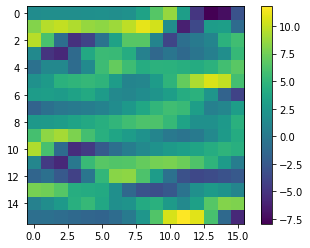

In [4]:
# set random seed if reproducibility  is important
#numpy.random.seed(42)
#torch.manual_seed(42)

# Sample ground truth trajectory
X = simulator.sample()
#print(X.shape)

plt.imshow(X.T)
plt.colorbar()
plt.show()

## I.2) Observation

In [5]:
# Sample ground truth trajectory
X = simulator.sample()

# define observation operator
H = Observation_operator_L96(p=p_drop, subsample_t=subsample_t,nonlin=h_nonlin)

# define observation simulator
simulator_obs=Simulator_obs(H, sigma_perc_b=sigma_perc_b, sigma_perc_obs=sigma_perc_obs) 

# sample observation from ground truth trajectory
Xb, sigma_b, Bm1_mask, Y, sigma_obs, Rm1_mask = simulator_obs.sample(X)

Bm1 = Bm1_mask/(sigma_b**2)
Bm1[Bm1!=Bm1]=0

Rm1 = Rm1_mask/(sigma_obs**2)
Rm1[Rm1!=Rm1]=0

# Data assimilation window 0->T, T->-1 Forecast window
Y[T:,:]=0
Rm1[T:,:]=0

Y_plot = Y.clone()
Y_plot[Y==0]=float('nan')

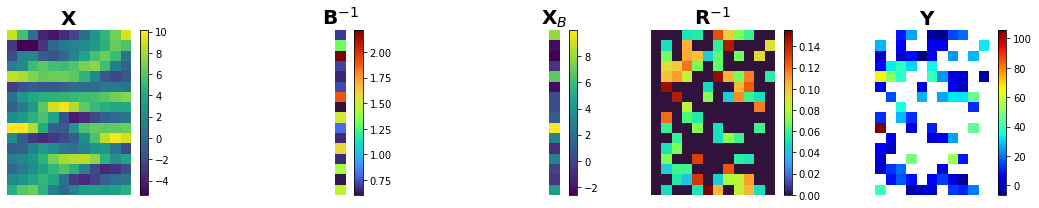

In [6]:
plt.figure(figsize=(15,3))

# plot diag(covariance) / Observations
plt.subplot(1,5,3) 
plt.imshow(Xb.reshape(-1,1))
plt.colorbar()
plt.axis('off')
plt.title(r'$\mathbf{X}_B$',fontsize=20)

plt.subplot(1,5,2) 
plt.imshow((Bm1_mask/(sigma_b**2)).reshape(-1,1), cmap='turbo')
plt.colorbar()
plt.axis('off')
plt.title(r'$\mathbf{B}^{-1}$',fontsize=20)

#plt.show()

#plt.figure(figsize=(12,6))

plt.subplot(1,5,5)
plt.imshow(Y_plot[0:T].T,cmap='jet')
#plt.colorbar(fraction=0.046, pad=0.04)
plt.colorbar()
plt.title(r'$\mathbf{Y}$',fontsize=20)
plt.axis('off')

plt.subplot(1,5,4) 
plt.imshow(Rm1[0:T].T, cmap='turbo')
#plt.colorbar(fraction=0.046, pad=0.04)
plt.colorbar()
plt.title(r'$\mathbf{R}^{-1}$',fontsize=20)
plt.axis('off')

plt.subplot(1,5,1) 
plt.imshow(X[0:T].T)
#plt.colorbar(fraction=0.046, pad=0.04)
plt.colorbar()
plt.title(r'$\mathbf{X}$',fontsize=20)
plt.axis('off')

plt.tight_layout()
#plt.subplots_adjust()
plt.savefig("../figures/data.pdf", bbox_inches='tight')
plt.show()

# II. Assimilation

## II.1) strong constraint 4DVAR

In [7]:
# instanciate 4DVAR
assimilation_4dv = strong_4DVar(dynamics, H)

# fit / optimization
assimilation_4dv.fit(Y, Rm1, Xb, Bm1)

# estimated state
X_4dv=assimilation_4dv.X_hat

N iter: 139


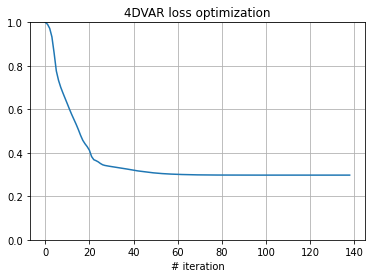

In [8]:
print('N iter:', assimilation_4dv.n_iter)
plt.plot(assimilation_4dv.losses)

plt.title('4DVAR loss optimization')
plt.xlabel('# iteration')
plt.ylim([0,1])
plt.grid()
plt.show()

## II.2) Approximate Bayesian Computation - rejection sampling

In [9]:
# instanciate ABC-r sampler
assimilation_abc=ABC_strong_4DVar(dynamics, H, 
                                  N_trial=N_trial_abc, 
                                  percent_select_abc=percent_select_abc, 
                                  percent_select_prior=percent_select_prior)

# sampling
assimilation_abc.fit(Y, Rm1, Xb, Bm1)

# sampled prior
X_prior = assimilation_abc.X_prior

# results posterior
X_abc = assimilation_abc.X_abc

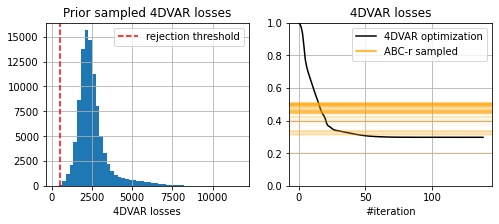

In [10]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)

plt.hist(np.array(assimilation_abc.losses),50);
plt.axvline(assimilation_abc.losses_abc.max(),color='red',linestyle='--', label='rejection threshold')
plt.title('Prior sampled 4DVAR losses')
plt.xlabel('4DVAR losses')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(assimilation_4dv.losses, label = '4DVAR optimization',color='black')


for i in range(len(assimilation_abc.losses_abc)):
    plt.axhline(assimilation_abc.losses_abc[i].numpy()/assimilation_4dv.K,color='orange', alpha=0.1)
    
# legend only 
plt.axhline(1.1,color='orange', alpha=1, label='ABC-r sampled')    
plt.ylim([0,1])
plt.title('4DVAR losses')
plt.xlabel('#iteration')
plt.legend()
plt.grid()

plt.savefig("../figures/ABCr_opti.pdf", bbox_inches='tight')

plt.show()

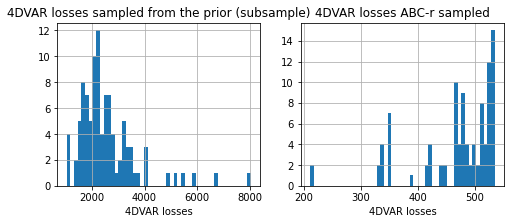

In [11]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.hist(np.array(assimilation_abc.losses_prior),50);
plt.title('4DVAR losses sampled from the prior (subsample)')
plt.xlabel('4DVAR losses')
plt.grid()

plt.subplot(1,2,2)
plt.hist(np.array(assimilation_abc.losses_abc),50);
plt.title('4DVAR losses ABC-r sampled')
plt.xlabel('4DVAR losses')
plt.grid()

plt.show()

## II.3) Ensemble of 4DVAR

In [12]:
# instanciate 
assimilation_E4dv = Ensemble_strong_4DVar(dynamics, H, N_member=N_member_E4dv)

# sample and fit
assimilation_E4dv.fit(Y, Rm1, Xb, Bm1)

# estimated states
X_E4dv=assimilation_E4dv.Ensemble

Nan loss: failed to converge
Nan loss: failed to converge
Nan loss: failed to converge
Nan loss: failed to converge
Nan loss: failed to converge
Nan loss: failed to converge
Nan loss: failed to converge


In [13]:
# filtering non-converged members
nan = X_E4dv.mean(axis=1).mean(axis=1)
X_E4dv=X_E4dv[nan==nan,:,:]
print('percentage of convergence:',100*X_E4dv.shape[0]/N_member_E4dv)

percentage of convergence: 93.0


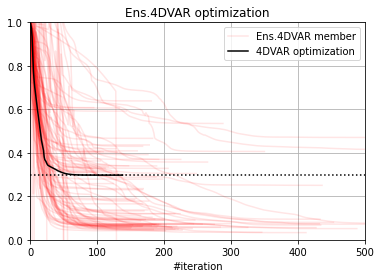

In [14]:
plt.figure(figsize=(6,4))

for i in range(assimilation_E4dv.Elosses.shape[0]):
    plt.plot(assimilation_E4dv.Elosses[i], color='red', alpha=0.1)
plt.ylim([0,1])
plt.xlim([0,500])

# legend only
plt.plot(1.1, color='red', alpha=0.1, label = 'Ens.4DVAR member')

plt.plot(assimilation_4dv.losses, label = '4DVAR optimization',color='black')
plt.axhline(assimilation_4dv.losses[assimilation_4dv.n_iter-1],color='black',linestyle='dotted')

plt.title('Ens.4DVAR optimization')
plt.xlabel('#iteration')
plt.grid()
plt.legend()

plt.savefig("../figures/Ens4DVAR_opti.pdf", bbox_inches='tight')
plt.show()

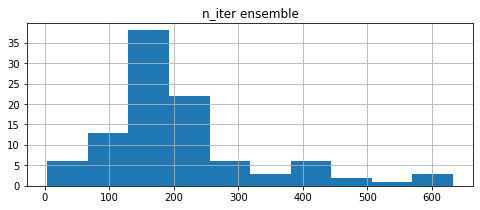

In [15]:
plt.figure(figsize=(8,3))

plt.hist(assimilation_E4dv.En_iter.numpy())
plt.title('n_iter ensemble')
plt.grid()
plt.show()

plt.show()

## II.4) 4D-Variational Inference

In [16]:
vi_assimilation=VI_strong_4DVar(dynamics, H,
                                batch_size=batch_size,lr=lr,N_iter=N_iter, N_final_sample=N_vi_sample)
vi_assimilation.fit(Y, Rm1, Xb, Bm1)
X_vi = vi_assimilation.X_vi

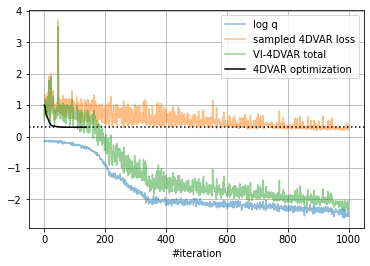

In [26]:
plt.figure(figsize=(6,4))

plt.plot(np.array(vi_assimilation.losses_nll), label = 'log q', alpha=0.5)
plt.plot(np.array(vi_assimilation.losses_4dvar), label = 'sampled 4DVAR loss', alpha=0.5)
plt.plot(np.array(vi_assimilation.losses), label = 'VI-4DVAR total', alpha=0.5)

plt.plot(assimilation_4dv.losses, label = '4DVAR optimization',color='black')
plt.axhline(assimilation_4dv.losses[assimilation_4dv.n_iter-1],color='black',linestyle='dotted')

plt.xlabel('#iteration')
plt.legend()
plt.grid()
#plt.ylim([-1,0])
#plt.yscale('log')

plt.savefig("../figures/VI4DVAR_opti.pdf", bbox_inches='tight')
plt.show()

# III. Performance comparison

## III.1) Error of the mean

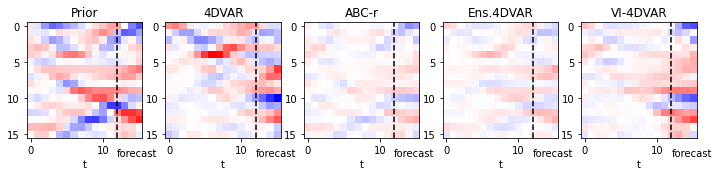

In [18]:
mean_prior=X_prior.mean(axis=0)
mean_abc=X_abc.mean(axis=0)
mean_E4dv=X_E4dv.mean(axis=0)
mean_vi4dv=X_vi.mean(axis=0)

vma = max( (X-mean_abc).max(), (X-X_4dv).max(), (X-X_E4dv).max(),(X-X_vi).max())
vmi = min( (X-mean_abc).min(), (X-X_4dv).min(), (X-X_E4dv).min(),(X-X_vi).min())
vma = max(abs(vma), abs(vmi))
vmi = -vma

plt.figure(figsize=(12,6))

plt.subplot(1,5,1)
plt.imshow((X-mean_prior).T,cmap='seismic',vmin=vmi,vmax=vma)
plt.axvline(T,color='black',linestyle='--')
plt.text(T,Nx+2,'forecast')
plt.xlabel('t')
plt.title('Prior')
#plt.colorbar()

plt.subplot(1,5,2)
plt.imshow((X-X_4dv).T,cmap='seismic',vmin=vmi,vmax=vma)
plt.axvline(T,color='black',linestyle='--')
plt.text(T,Nx+2,'forecast')
plt.xlabel('t')
plt.title('4DVAR')
#plt.colorbar()

plt.subplot(1,5,3)
plt.imshow((X-mean_abc).T,cmap='seismic',vmin=vmi,vmax=vma)
plt.axvline(T,color='black',linestyle='--')
plt.text(T,Nx+2,'forecast')
plt.xlabel('t')
plt.title('ABC-r')
#plt.colorbar()

plt.subplot(1,5,4)
plt.imshow((X-mean_E4dv).T,cmap='seismic',vmin=vmi,vmax=vma)
plt.axvline(T,color='black',linestyle='--')
plt.text(T,Nx+2,'forecast')
plt.xlabel('t')
plt.title('Ens.4DVAR')
#plt.colorbar()

plt.subplot(1,5,5)
plt.imshow((X-mean_vi4dv).T,cmap='seismic',vmin=vmi,vmax=vma)
plt.axvline(T,color='black',linestyle='--')
plt.text(T,Nx+2,'forecast')
plt.xlabel('t')
plt.title('VI-4DVAR')
#plt.colorbar()

plt.savefig("../figures/mean_error.pdf", bbox_inches='tight')
plt.show()

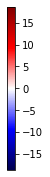

In [19]:
vma = max( (X-mean_abc).max(), (X-X_4dv).max(), (X-X_E4dv).max(),(X-X_vi).max())
vmi = min( (X-mean_abc).min(), (X-X_4dv).min(), (X-X_E4dv).min(),(X-X_vi).min())
vma = max(abs(vma), abs(vmi))
vmi = -vma

a = np.array([[0,1]])
plt.figure(figsize=(3, 3))
img = plt.imshow(a,vmin=vmi,vmax=vma,cmap='seismic')
plt.gca().set_visible(False)
#cax = plt.axes('(m)')
plt.colorbar();#, cax=cax)
plt.savefig("../figures/colorbar_mean_error.pdf", bbox_inches='tight')
plt.show()

## III.2) Standard deviation 

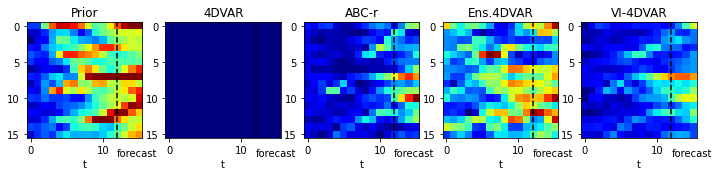

In [20]:
vmax_std= 4
vmin_std = 0

std_prior=X_prior.std(axis=0)
std_abc=X_abc.std(axis=0)
std_E4dv = X_E4dv.std(axis=0)
std_vi4dv = X_vi.std(axis=0)

plt.figure(figsize=(12,6))

plt.subplot(1,5,1)
plt.imshow(std_prior.T,cmap='jet', vmax=vmax_std)
plt.axvline(T,color='black',linestyle='--')
plt.text(T,Nx+2,'forecast')
plt.xlabel('t')
plt.title('Prior')
#plt.colorbar()

plt.subplot(1,5,2)
plt.imshow(torch.zeros(X.shape).T ,cmap='jet', vmax=vmax_std)
plt.axvline(T,color='black',linestyle='--')
plt.text(T,Nx+2,'forecast')
plt.xlabel('t')
plt.title('4DVAR')

plt.subplot(1,5,3)
plt.imshow(std_abc.T,cmap='jet',vmax=vmax_std)
plt.axvline(T,color='black',linestyle='--')
plt.text(T,Nx+2,'forecast')
plt.xlabel('t')
plt.title('ABC-r')
#plt.colorbar()

plt.subplot(1,5,4)
plt.imshow(std_E4dv.T ,cmap='jet',vmax=vmax_std)
plt.axvline(T,color='black',linestyle='--')
plt.text(T,Nx+2,'forecast')
plt.xlabel('t')
plt.title('Ens.4DVAR')
#plt.colorbar()

plt.subplot(1,5,5)
plt.imshow(std_vi4dv.T,cmap='jet',vmax=vmax_std)
plt.axvline(T,color='black',linestyle='--')
plt.text(T,Nx+2,'forecast')#, color='white')
plt.title('VI-4DVAR')
plt.xlabel('t')
#plt.colorbar()

plt.savefig("../figures/std.pdf", bbox_inches='tight')
plt.show()

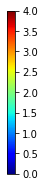

In [21]:
a = np.array([[0,1]])
plt.figure(figsize=(3, 3))
img = plt.imshow(a,vmin=vmin_std,vmax=vmax_std,cmap='jet')
plt.gca().set_visible(False)
#cax = plt.axes('(m)')
plt.colorbar();#, cax=cax)
plt.savefig("../figures/colorbar_std.pdf", bbox_inches='tight')
plt.show()

## III.3) Distribution at each grid points (space and time)

-X coordinates:  0  -time:  -1  --


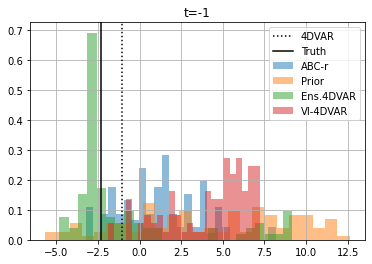

-X coordinates:  1  -time:  -1  --


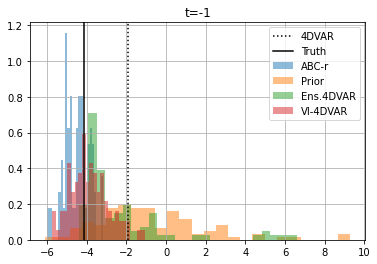

-X coordinates:  2  -time:  -1  --


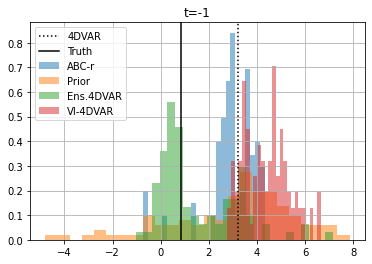

-X coordinates:  3  -time:  -1  --


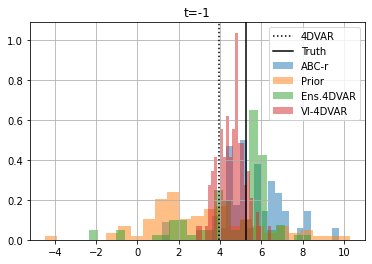

-X coordinates:  4  -time:  -1  --


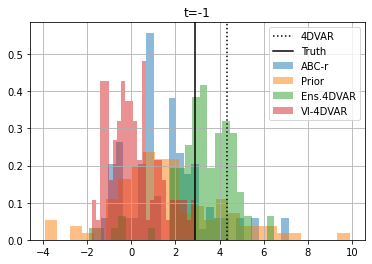

-X coordinates:  5  -time:  -1  --


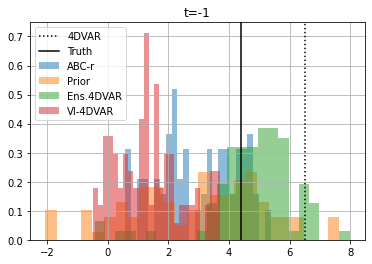

-X coordinates:  6  -time:  -1  --


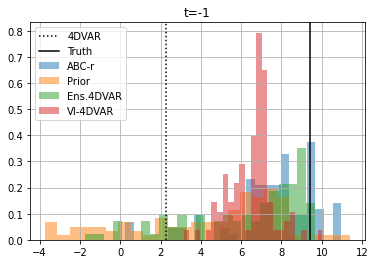

-X coordinates:  7  -time:  -1  --


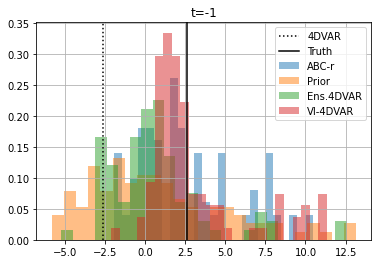

-X coordinates:  8  -time:  -1  --


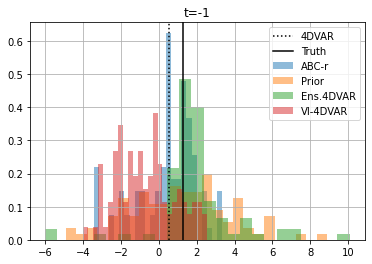

-X coordinates:  9  -time:  -1  --


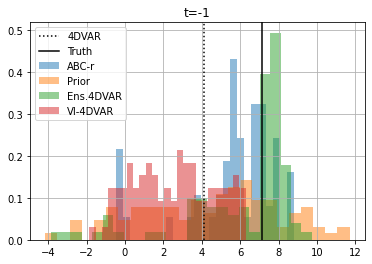

-X coordinates:  10  -time:  -1  --


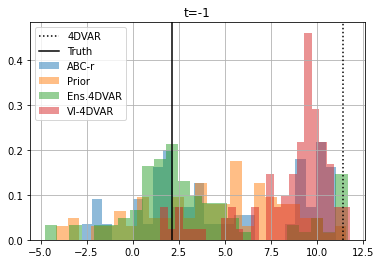

-X coordinates:  11  -time:  -1  --


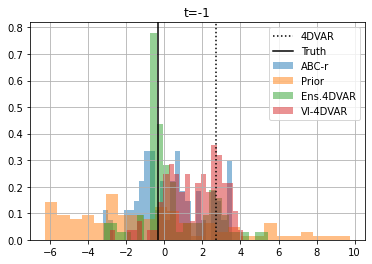

-X coordinates:  12  -time:  -1  --


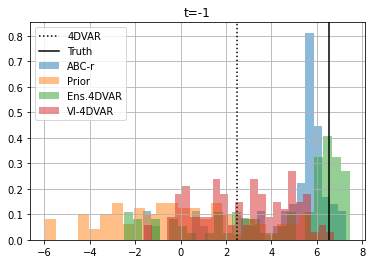

-X coordinates:  13  -time:  -1  --


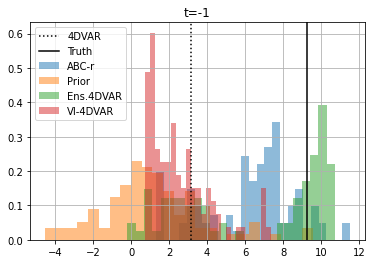

-X coordinates:  14  -time:  -1  --


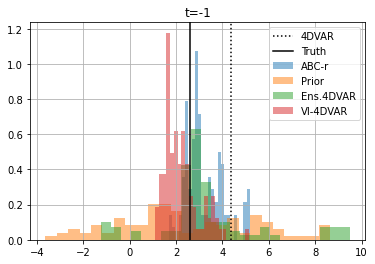

-X coordinates:  15  -time:  -1  --


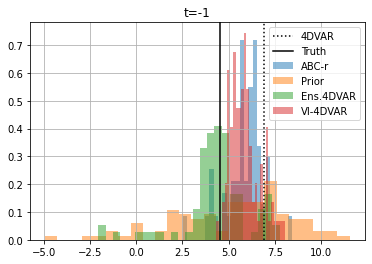

In [22]:
# select time-step to plot
t_to_plot = [-1]

# select coordinate to plot

x_to_plot = range(X.shape[1])
for n in x_to_plot:
    
    for t in t_to_plot:
        
        print('-X coordinates: ',n,' -time: ',t,' --')

        #plt.figure(figsize=(10,2))
        plt.title('t='+str( t))
        plt.hist(X_abc[:,t,n].numpy(),25, alpha=0.5,density=True,label='ABC-r')
        plt.hist(X_prior[:,t,n].numpy(),25, alpha=0.5,density=True,label='Prior')
        plt.hist(X_E4dv[:,t,n].numpy(),25, alpha=0.5,density=True,label='Ens.4DVAR')
        plt.hist(X_vi[:,t,n].numpy(),25, alpha=0.5,density=True,label='VI-4DVAR')
        plt.axvline(X_4dv[t,n],label='4DVAR',color='black',linestyle='dotted')
        plt.axvline(X[t,n],label='Truth',color='black',linestyle='-')
        plt.legend()
        plt.grid()

        plt.show()

## III.4) Evolution in time at a fixed coordinate in space

-X coordinates:  0


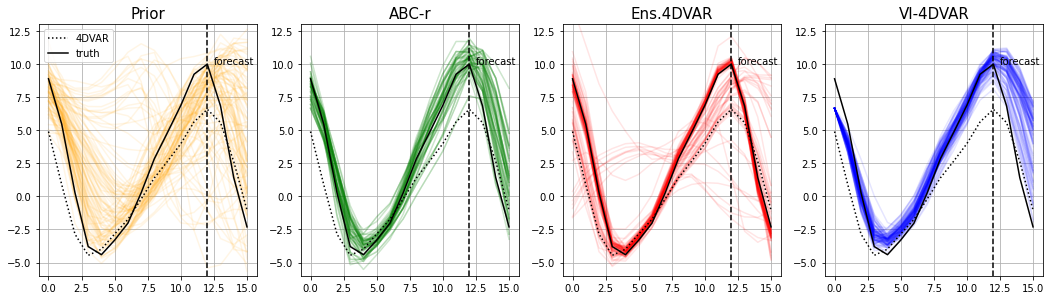

-X coordinates:  1


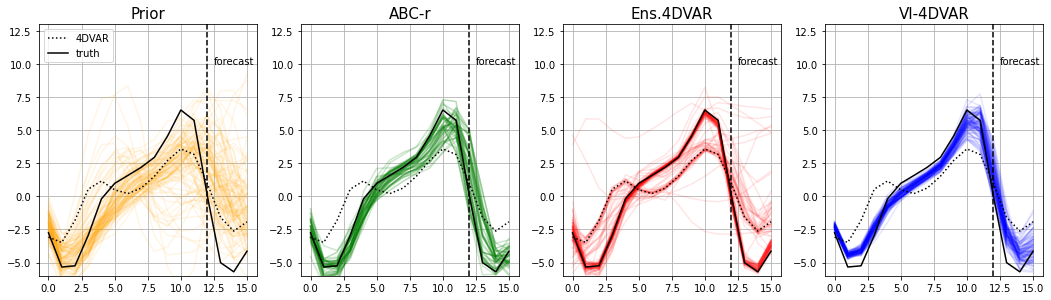

-X coordinates:  2


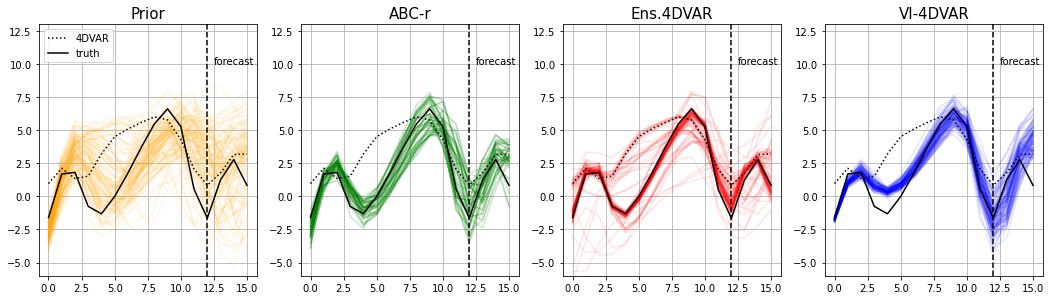

-X coordinates:  3


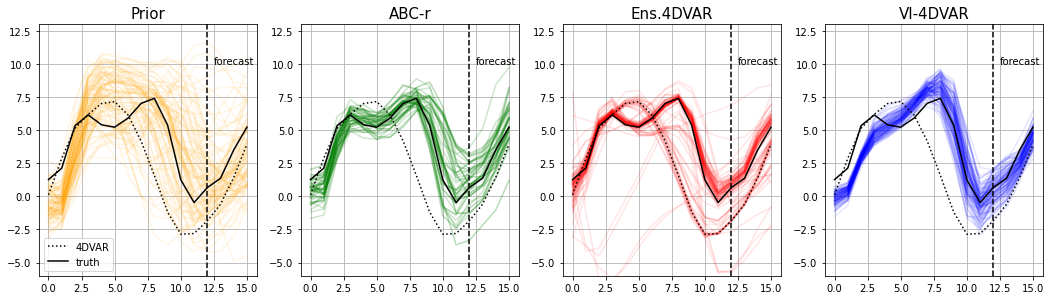

-X coordinates:  4


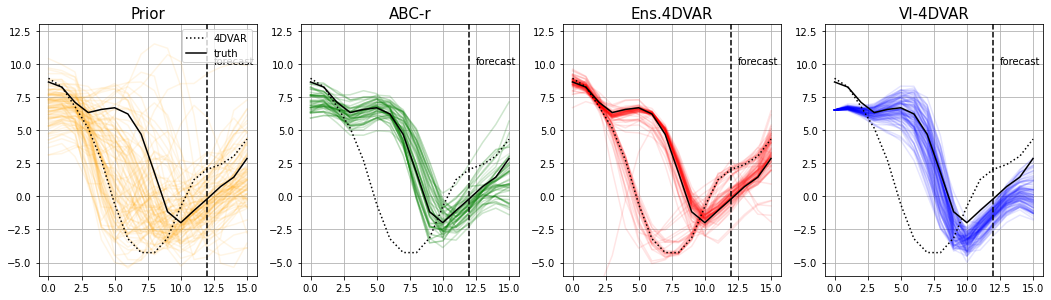

-X coordinates:  5


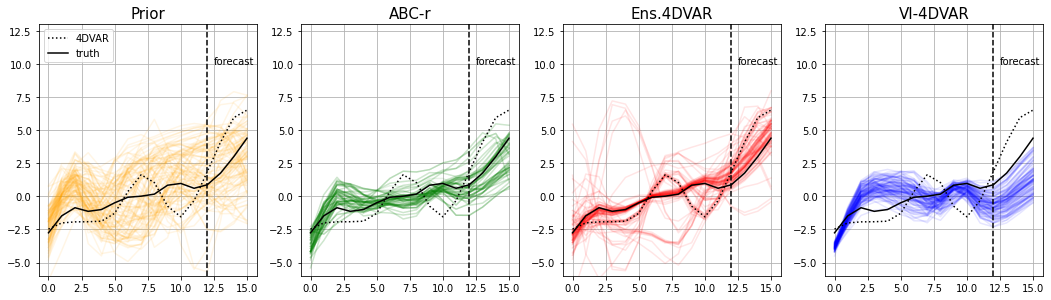

-X coordinates:  6


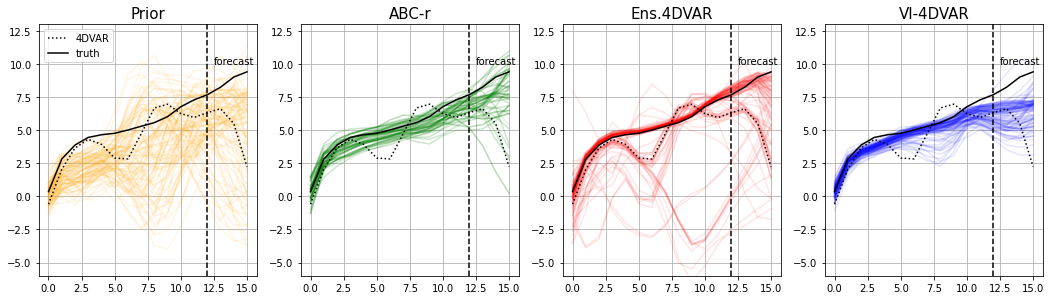

-X coordinates:  7


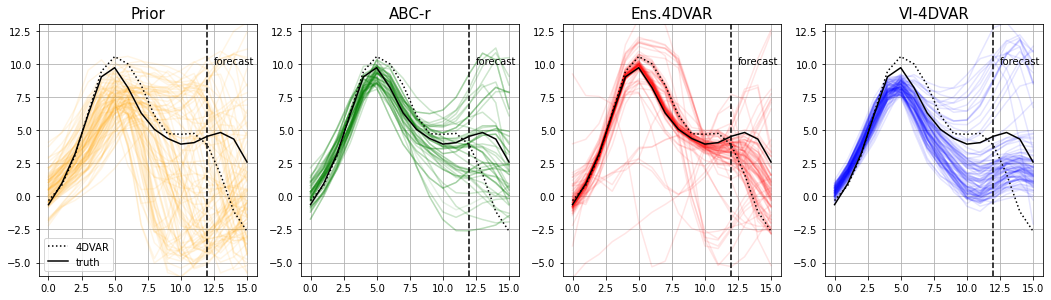

-X coordinates:  8


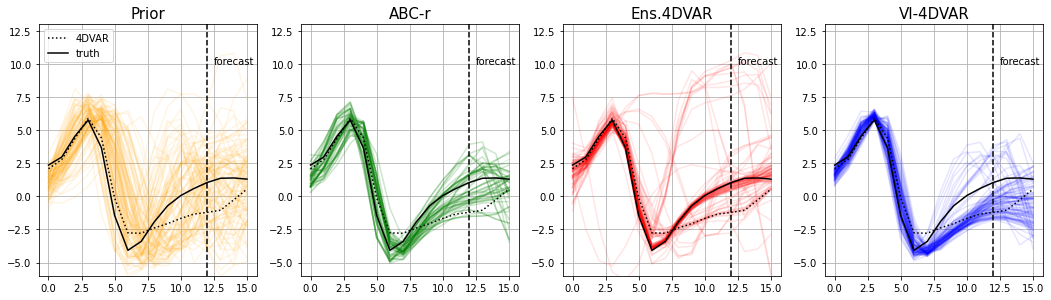

-X coordinates:  9


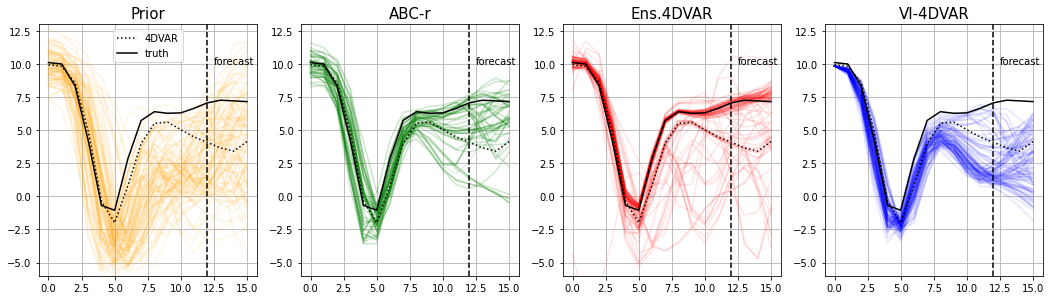

-X coordinates:  10


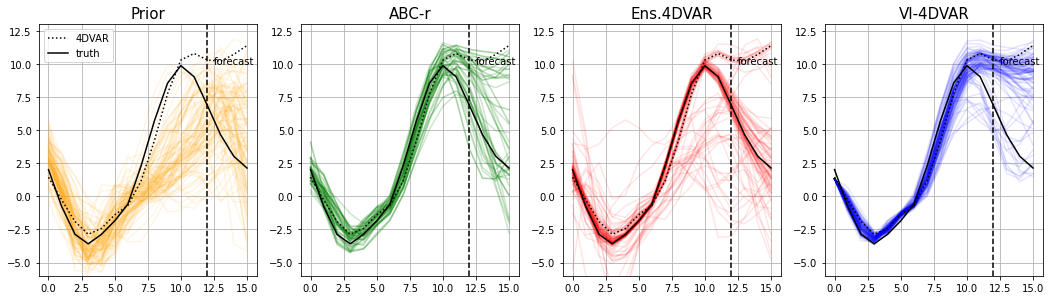

-X coordinates:  11


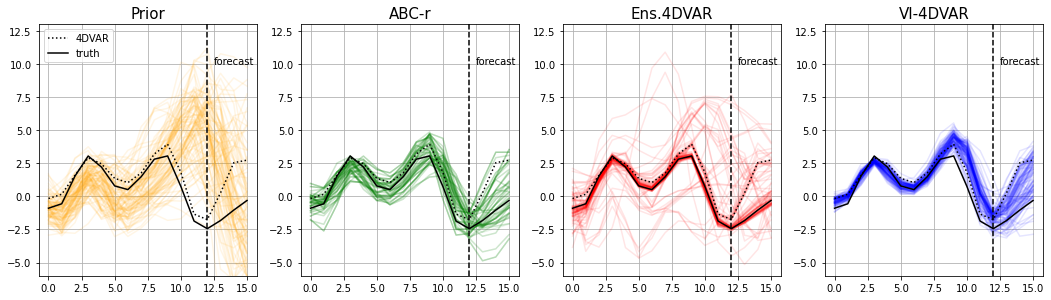

-X coordinates:  12


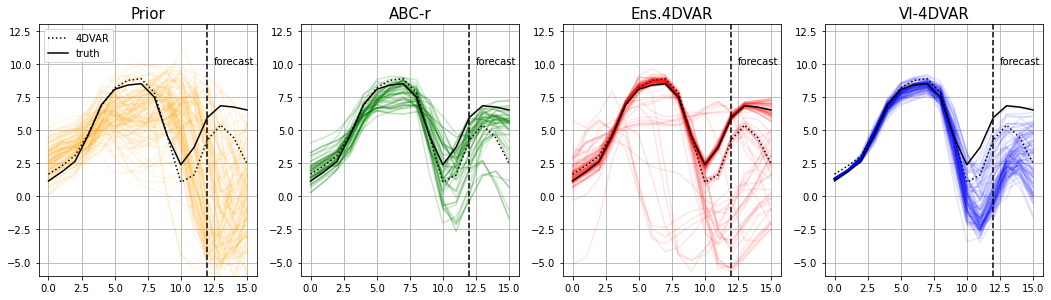

-X coordinates:  13


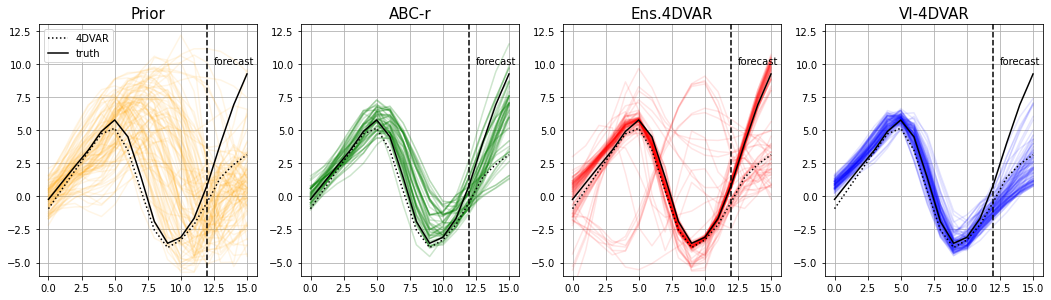

-X coordinates:  14


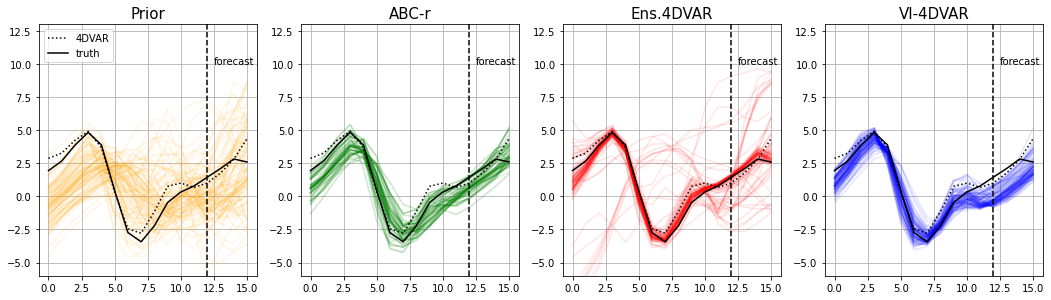

-X coordinates:  15


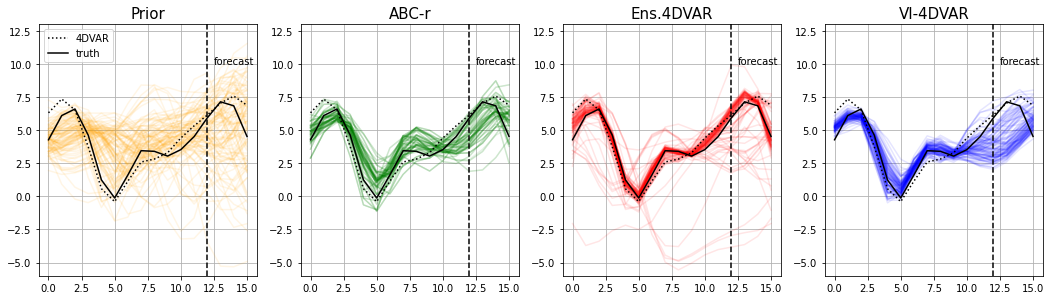

In [23]:
Y_scatter=Y.clone()
subsample_prior=1#int((percent_select_prior/100)*(N_trial_abc/100))
save_plot = [0, 2, 4, 6, 7, 15]

for n in range(X_abc.shape[2]):
    print('-X coordinates: ',n)
    plt.figure(figsize=(18,6))
    
    plt.gca().set_aspect('equal')
    
    plt.subplot(1,4,1)
    
    plt.title('Prior',fontsize = 15)
    for j in range(0, X_prior.shape[0], subsample_prior):
        if j == 0:
            plt.plot(X_prior[j,:,n],color='orange', alpha=0.1)#,label='prior')
        else:
            plt.plot(X_prior[j,:,n],color='orange', alpha=0.1)
            
    plt.plot(X_4dv[:,n],color='black',linestyle='dotted',label='4DVAR')
    plt.plot(X[:,n],color='black',label='truth')
    plt.axvline(T,color='black',linestyle='--')
    plt.text(T+0.5,10,'forecast')#, color='white')
    
    #plt.xlim([0,16])
    plt.gca().set_aspect('equal')
    plt.ylim([-6,13])
    plt.legend()
    plt.grid()
        
    plt.subplot(1,4,2)
    plt.title('ABC-r',fontsize = 15)
    for i in range(X_abc.shape[0]):
        if i ==0:
            plt.plot(X_abc[i,:,n],color='green', alpha=0.1)#,label='ABC')
        else:
            plt.plot(X_abc[i,:,n],color='green', alpha=0.1)
    
    plt.plot(X_4dv[:,n],color='black',linestyle='dotted',label='4DVAR')
    plt.plot(X[:,n],color='black',label='truth')
    plt.axvline(T,color='black',linestyle='--')
    plt.text(T+0.5,10,'forecast')#, color='white')
    
    plt.gca().set_aspect('equal')
    plt.ylim([-6,13])
    plt.grid()
    
    
    plt.subplot(1,4,3)
    plt.title('Ens.4DVAR',fontsize = 15)
    
    for i in range(X_E4dv.shape[0]):
        if i ==0:
            plt.plot(X_E4dv[i,:,n],color='red', alpha=0.1,label='Ens.4DVAR')
        else:
            plt.plot(X_E4dv[i,:,n],color='red', alpha=0.1)
    
    plt.plot(X_4dv[:,n],color='black',linestyle='dotted',label='4DVAR')
    plt.plot(X[:,n],color='black',label='truth')
    plt.axvline(T,color='black',linestyle='--')
    plt.text(T+0.5,10,'forecast')#, color='white')
    
    plt.gca().set_aspect('equal')
    plt.ylim([-6,13])
    plt.grid()
    
    plt.subplot(1,4,4)
    plt.title('VI-4DVAR',fontsize = 15)
    
    for i in range(X_vi.shape[0]):
        if i ==0:
            plt.plot(X_vi[i,:,n],color='blue', alpha=0.1,label='posterior sample')
        else:
            plt.plot(X_vi[i,:,n],color='blue', alpha=0.1)
    
    plt.plot(X_4dv[:,n],color='black',linestyle='dotted',label='4DVAR')
    plt.plot(X[:,n],color='black',label='truth')
    plt.axvline(T,color='black',linestyle='--')
    plt.text(T+0.5,10,'forecast')#, color='white')
    
    plt.gca().set_aspect('equal')
    plt.ylim([-6,13])
    plt.grid()
    
    if n in save_plot:
        plt.savefig("../figures/time_density_"+str(n)+".pdf", bbox_inches='tight')
    plt.show()

## III.4) Covariance matrices

In [24]:
def cov(X):
    
    c = torch.matmul((X-X.mean(axis=0)).T, X-X.mean(axis=0))/(X.shape[0]-1)
    
    return c

t= 0


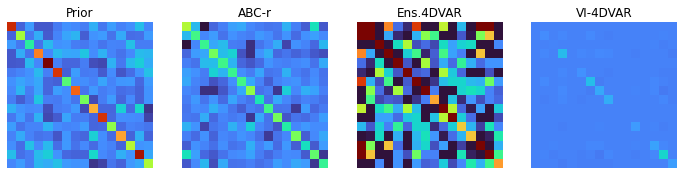

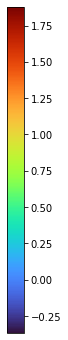

t= 1


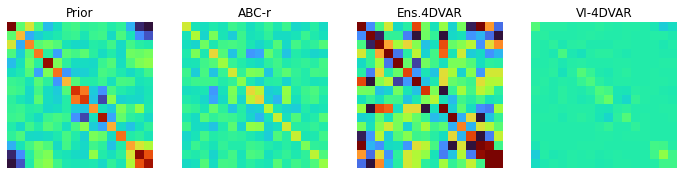

t= 2


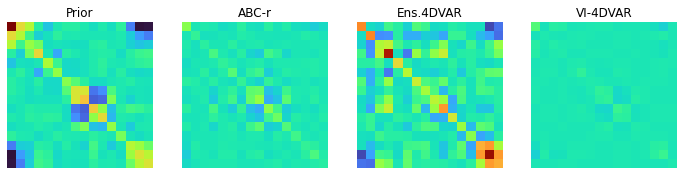

t= 3


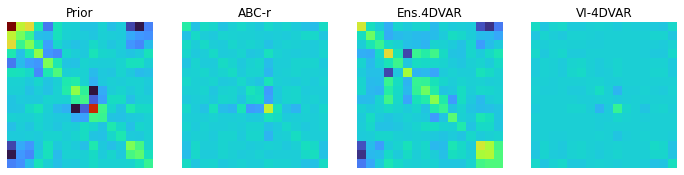

t= 4


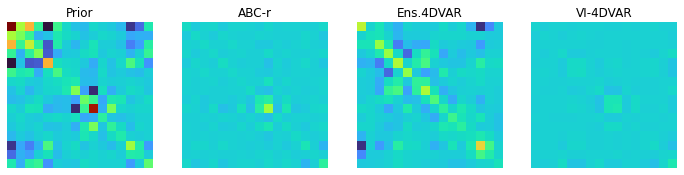

t= 5


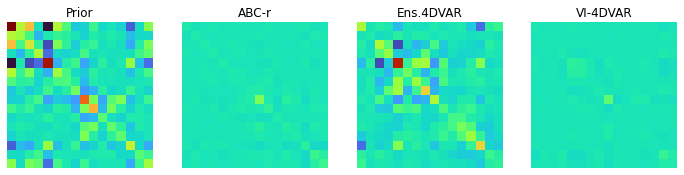

t= 6


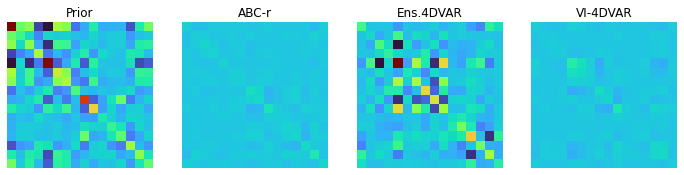

t= 7


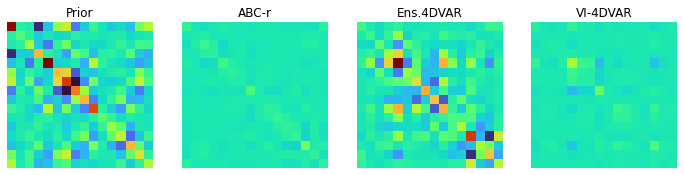

t= 8


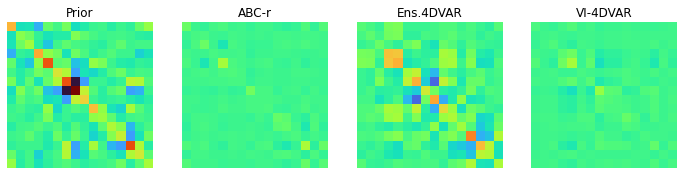

t= 9


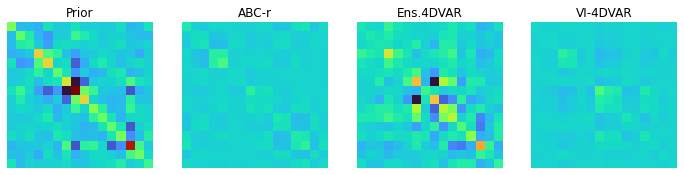

t= 10


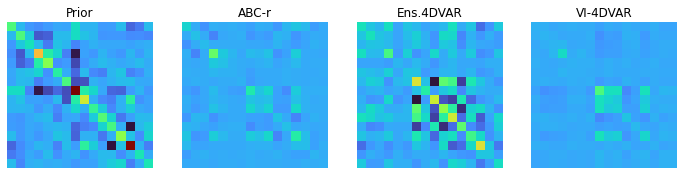

t= 11


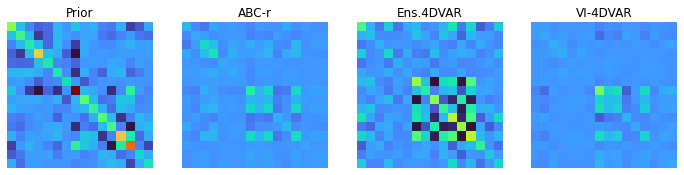

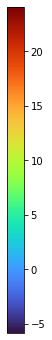

t= 12


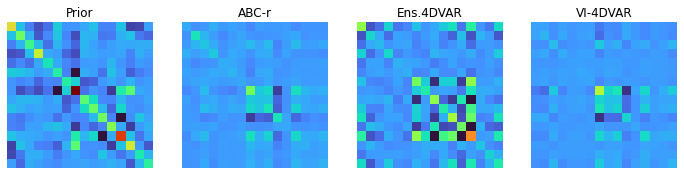

t= 13


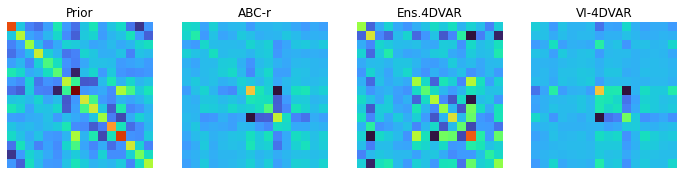

t= 14


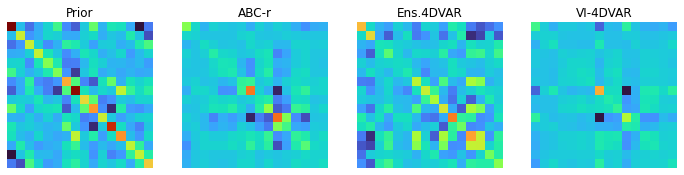

t= 15


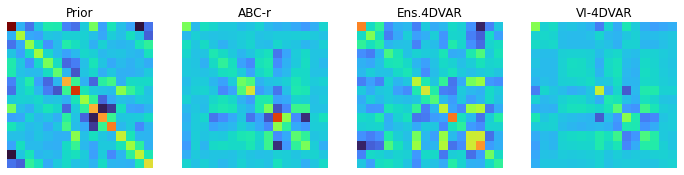

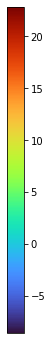

In [25]:
save_plot_cov = [0,11,15]

for t in range(T+4):
    
    print('t=',t)
    
    Xt_prior=X_prior[:,t,:]
    Xt_abc=X_abc[:,t,:]
    Xt_E4dv=X_E4dv[:,t,:]
    Xt_vi=X_vi[:,t,:]
    
    covt_prior=cov(Xt_prior)
    covt_abc=cov(Xt_abc)
    covt_E4dv=cov(Xt_E4dv)
    covt_vi=cov(Xt_vi)
    
    vma=max(covt_prior.max(),covt_abc.max())
    #
    #print(max(covt_prior.max(),covt_abc.max()))
    #print(min(covt_prior.min(),covt_abc.min()))
    vmi=min(covt_prior.min(),covt_abc.min())

    plt.figure(figsize=(12,6))
    
    plt.subplot(1,4,1)
    plt.imshow(covt_prior,vmin=vmi,vmax=vma,cmap='turbo')
    plt.axis('off')
    plt.title('Prior')
    #plt.title('cov-prior t='+str(t))
    #plt.colorbar()

    plt.subplot(1,4,2)
    plt.imshow(covt_abc,vmin=vmi,vmax=vma,cmap='turbo')
    plt.axis('off')
    plt.title('ABC-r')
    #plt.title('cov-abc t='+str(t))
    #plt.colorbar()
    
    plt.subplot(1,4,3)
    plt.imshow(covt_E4dv,vmin=vmi,vmax=vma,cmap='turbo')
    plt.axis('off')
    plt.title('Ens.4DVAR')
    #plt.title('Ens.4DVAR t='+str(t))
    #plt.colorbar()
    
    plt.subplot(1,4,4)
    plt.imshow(covt_vi,vmin=vmi,vmax=vma,cmap='turbo')
    plt.axis('off')
    plt.title('VI-4DVAR')
    #plt.title('VI-4DVAR t='+str(t))
    #plt.colorbar()
    
    if t in save_plot_cov:
        
        plt.savefig("../figures/covariance_t"+str(t)+".pdf", bbox_inches='tight')
        plt.show()

        a = np.array([[0,1]])
        plt.figure(figsize=(6,6))
        img = plt.imshow(a,vmin=vmi,vmax=vma,cmap='turbo')
        plt.gca().set_visible(False)
        #cax = plt.axes('(m)')
        plt.colorbar();#, cax=cax)
        plt.savefig("../figures/colorbar_covariance_t"+str(t)+".pdf",bbox_inches='tight')
        plt.show()
        
    else:
        plt.show()